<a href="https://colab.research.google.com/github/m-zaniolo/CEE690-ESAA/blob/main/Lab_04_planning_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Optimal reservoir sizing

In this class, we will optimize a reservoir sizing problem. Let's load inflow and release functions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.dpi'] = 600

url = 'https://raw.githubusercontent.com/m-zaniolo/CEE690-ESAA/main/data/'
inflow = np.loadtxt(url + 'inflow.txt', delimiter='\t') #m3/s
release = np.loadtxt(url + 'release4.txt', delimiter='\t') #m3/s
evap = np.loadtxt(url + 'netevap_Gibe1.txt', delimiter=' ') # load cyclostationary evaporation

# define constants
H = len(inflow) #length of the simulation horizon
sim_step = 60*60*24 #seconds per day
stor_to_surface = 0.0142


Let's define a function for the reservoir mass balance

In [3]:
def simulate(u):

  S = u*1e10
  # time convention
  inflow_ = np.concatenate(([-999], inflow))
  release_ = np.concatenate(([-999], release))

  # initialize storage vector
  s = np.zeros(len(inflow_))
  l = np.zeros(len(inflow_)) ### new
  r = np.zeros(len(inflow_)) ### new

  s[0] = S*0.7

  # mass balance
  for t in range(H):
    evaporation_t = evap[t%365]/1000*s[t]*stor_to_surface/sim_step
    ##### new
    # check release constraints
    r[t+1] = min( release_[t+1], s[t] )
    #####
    s[t+1] = s[t] + (inflow_[t+1] - r[t+1] - evaporation_t)*sim_step

    # check minimum storage constraint
    s[t+1] = max(0, s[t+1])

    l[t+1] = 0.0521*(s[t+1]**0.3589)   ### now in the for loop and before constraints

    s[t+1] = min(s[t+1], S) #check max storage constraint


  ### calculate indicators
  #indicator 1: construction cost
  i1 = 3*u**2

  #indicator 2: flood days
  Ny = len(l)/365
  l_threshold = 0.0521*(S**0.3589) #obtain maximum level threshold from max storage
  i2 = np.sum(l > l_threshold)/Ny

  #weighted sum
  J = w1*i1 + w2*i2

  return J



In [4]:
# With Gibe III reservoir size and "equal" objective weights, this function can be called as:

w1 = 0.5
w2 = 0.5

S = 1.47e10 #m3
u = 1.47
J = simulate(u)

print(J)

3.2413499999999997


# 1a. Weighted sum + discretized decision

Text(0, 0.5, 'objective (cost and flood)')

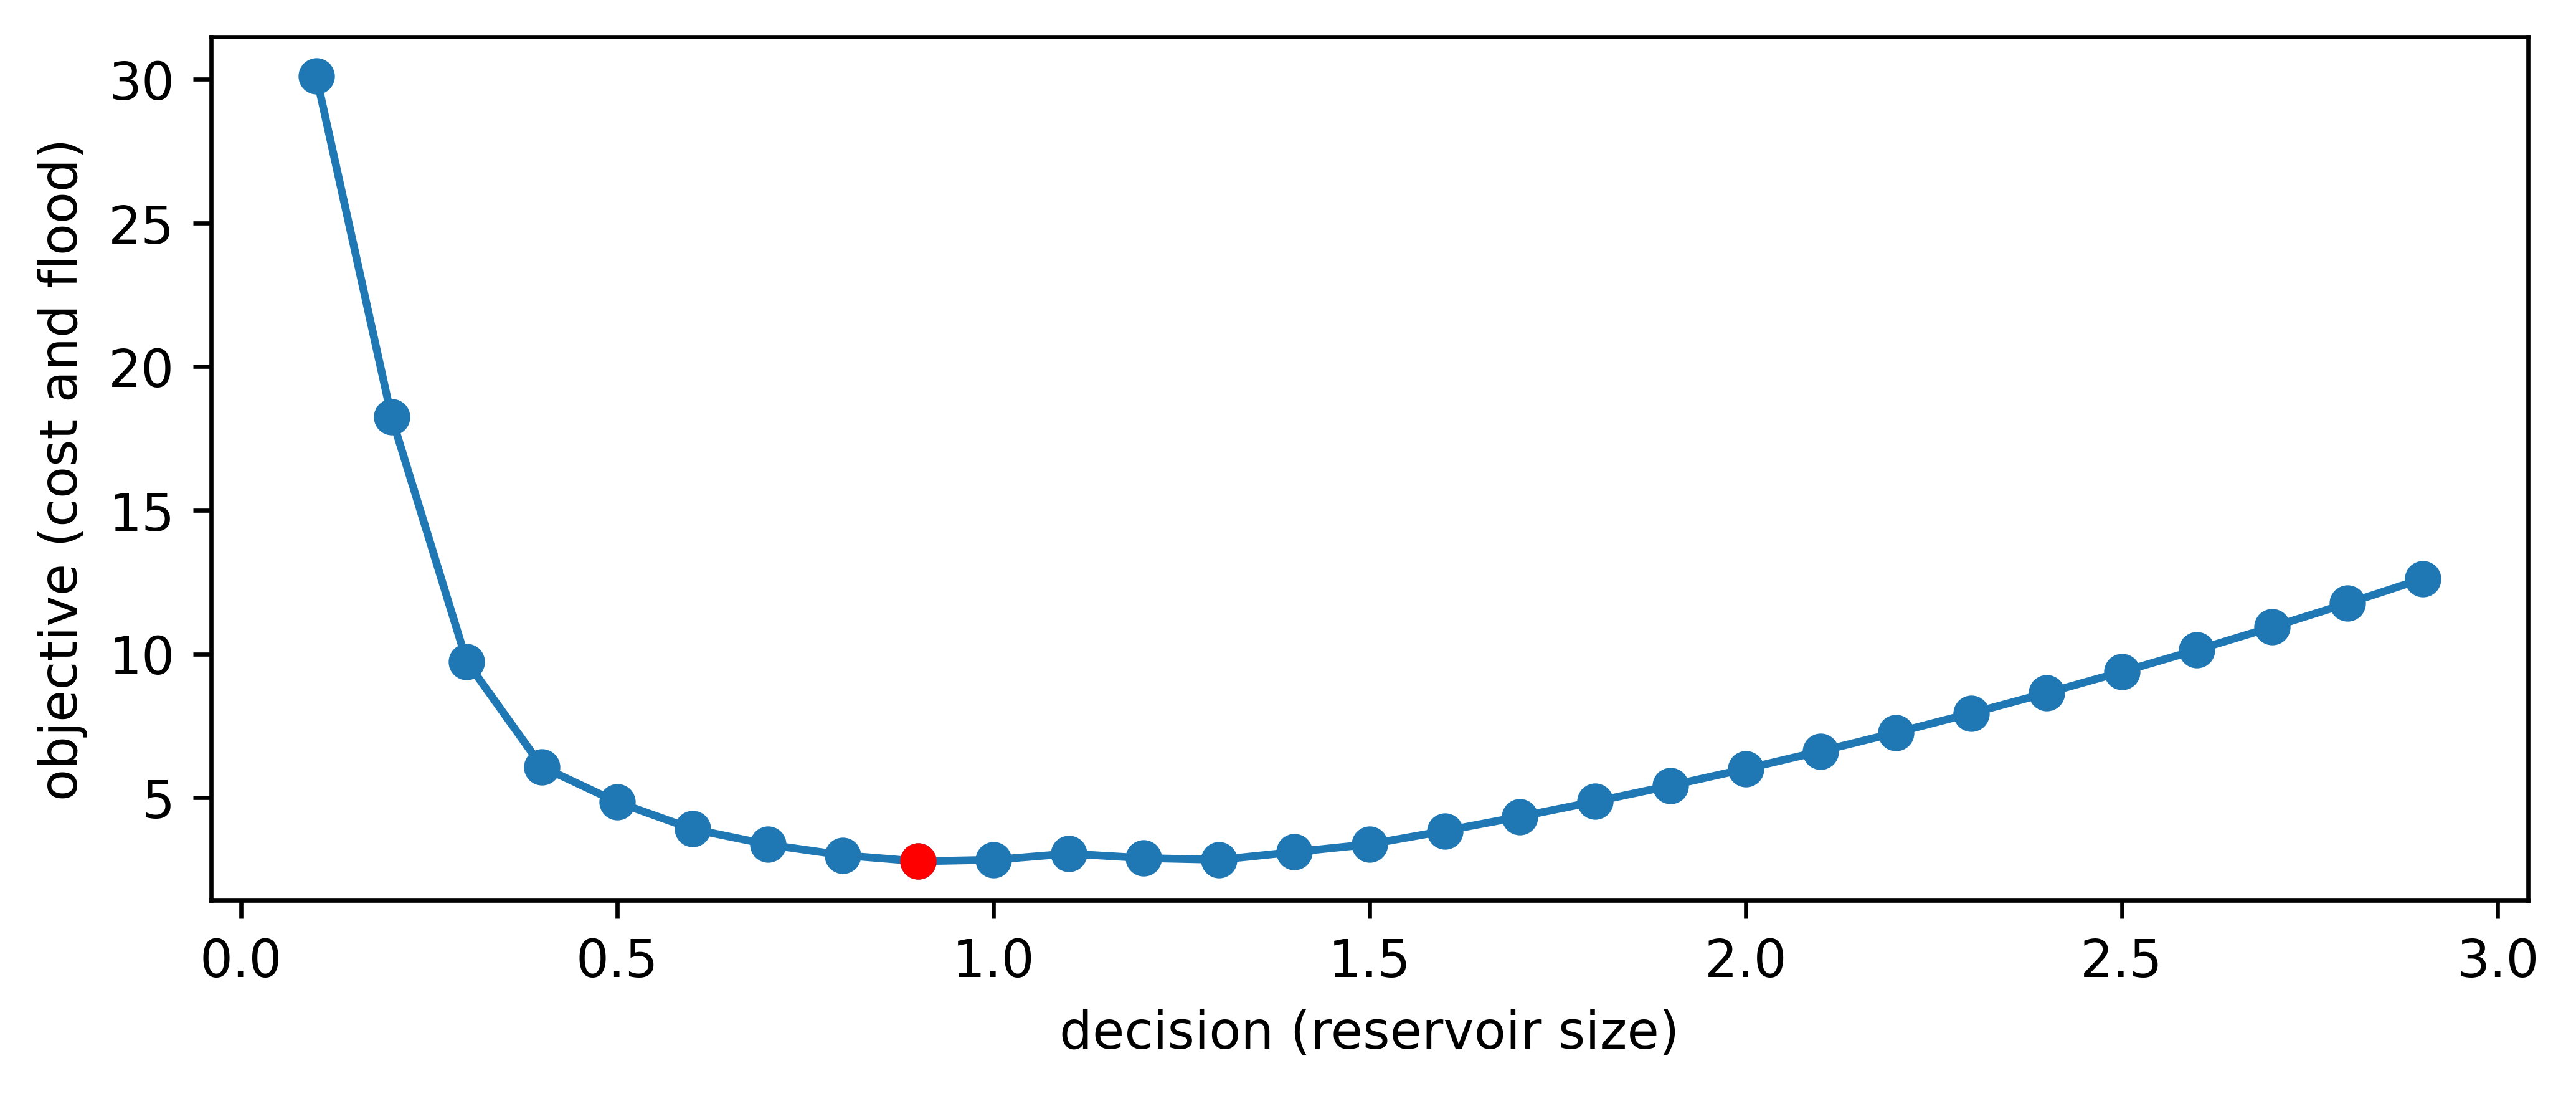

In [5]:
# let's set a combination of weights
w1 = 0.5
w2 = 0.5

# discretize the values of u
u_ = np.arange(0.1,3,0.1)

# iterate calculation of J for every value of u
J_ = np.zeros(len(u_))
for i in range(len(u_)):
  J_[i] = simulate(u_[i])

plt.figure(figsize=(8, 3))
plt.plot(u_, J_, '-o')

# best solution is where J is minimum
id_best = np.argmin(J_)
plt.plot(u_[id_best], J_[id_best], 'o', color='r')

plt.xlabel('decision (reservoir size)')
plt.ylabel('objective (cost and flood)')



Let's look at one objective at a time:

Text(0, 0.5, 'objective (J)')

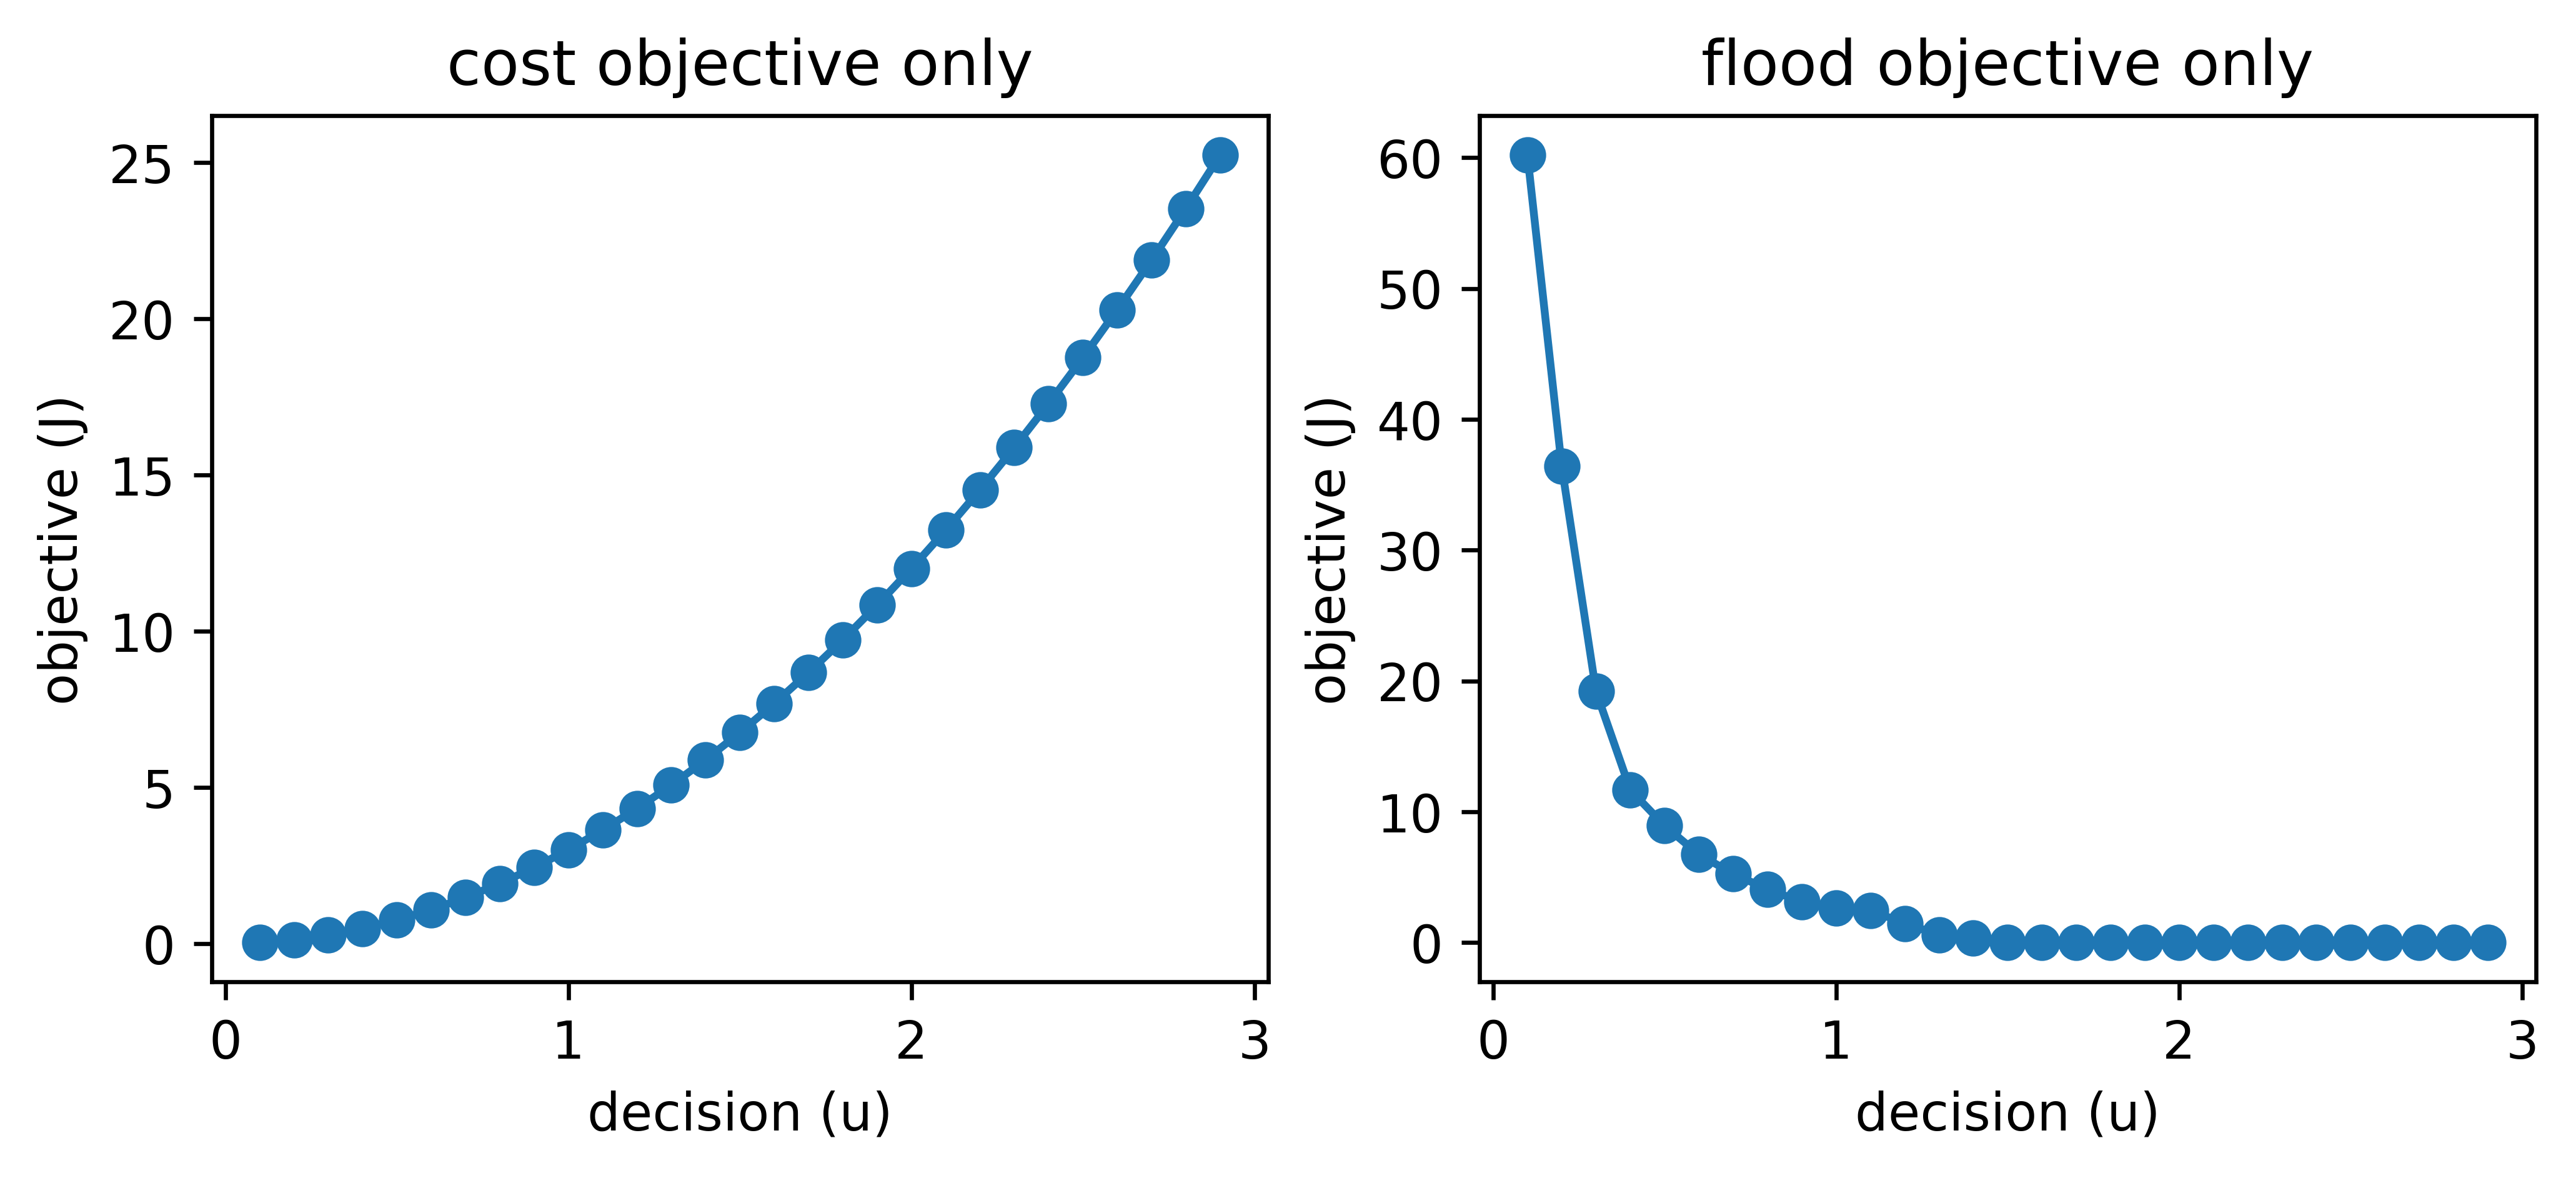

In [6]:
## cost objective only

w1 = 1
w2 = 0

u_ = np.arange(0.1,3,0.1)
J_ = []

for u in u_:
  J_.append(simulate(u))

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(u_, J_, '-o')
plt.title('cost objective only')
plt.xlabel('decision (u)')
plt.ylabel('objective (J)')

### flood objective only
w1 = 0
w2 = 1

u_ = np.arange(0.1,3,0.1)
J_ = []

for u in u_:
  J_.append(simulate(u))

plt.subplot(1, 2, 2)
plt.plot(u_, J_, '-o')
plt.title('flood objective only')
plt.xlabel('decision (u)')
plt.ylabel('objective (J)')


Let's explore the tradeoff between the two objectives:



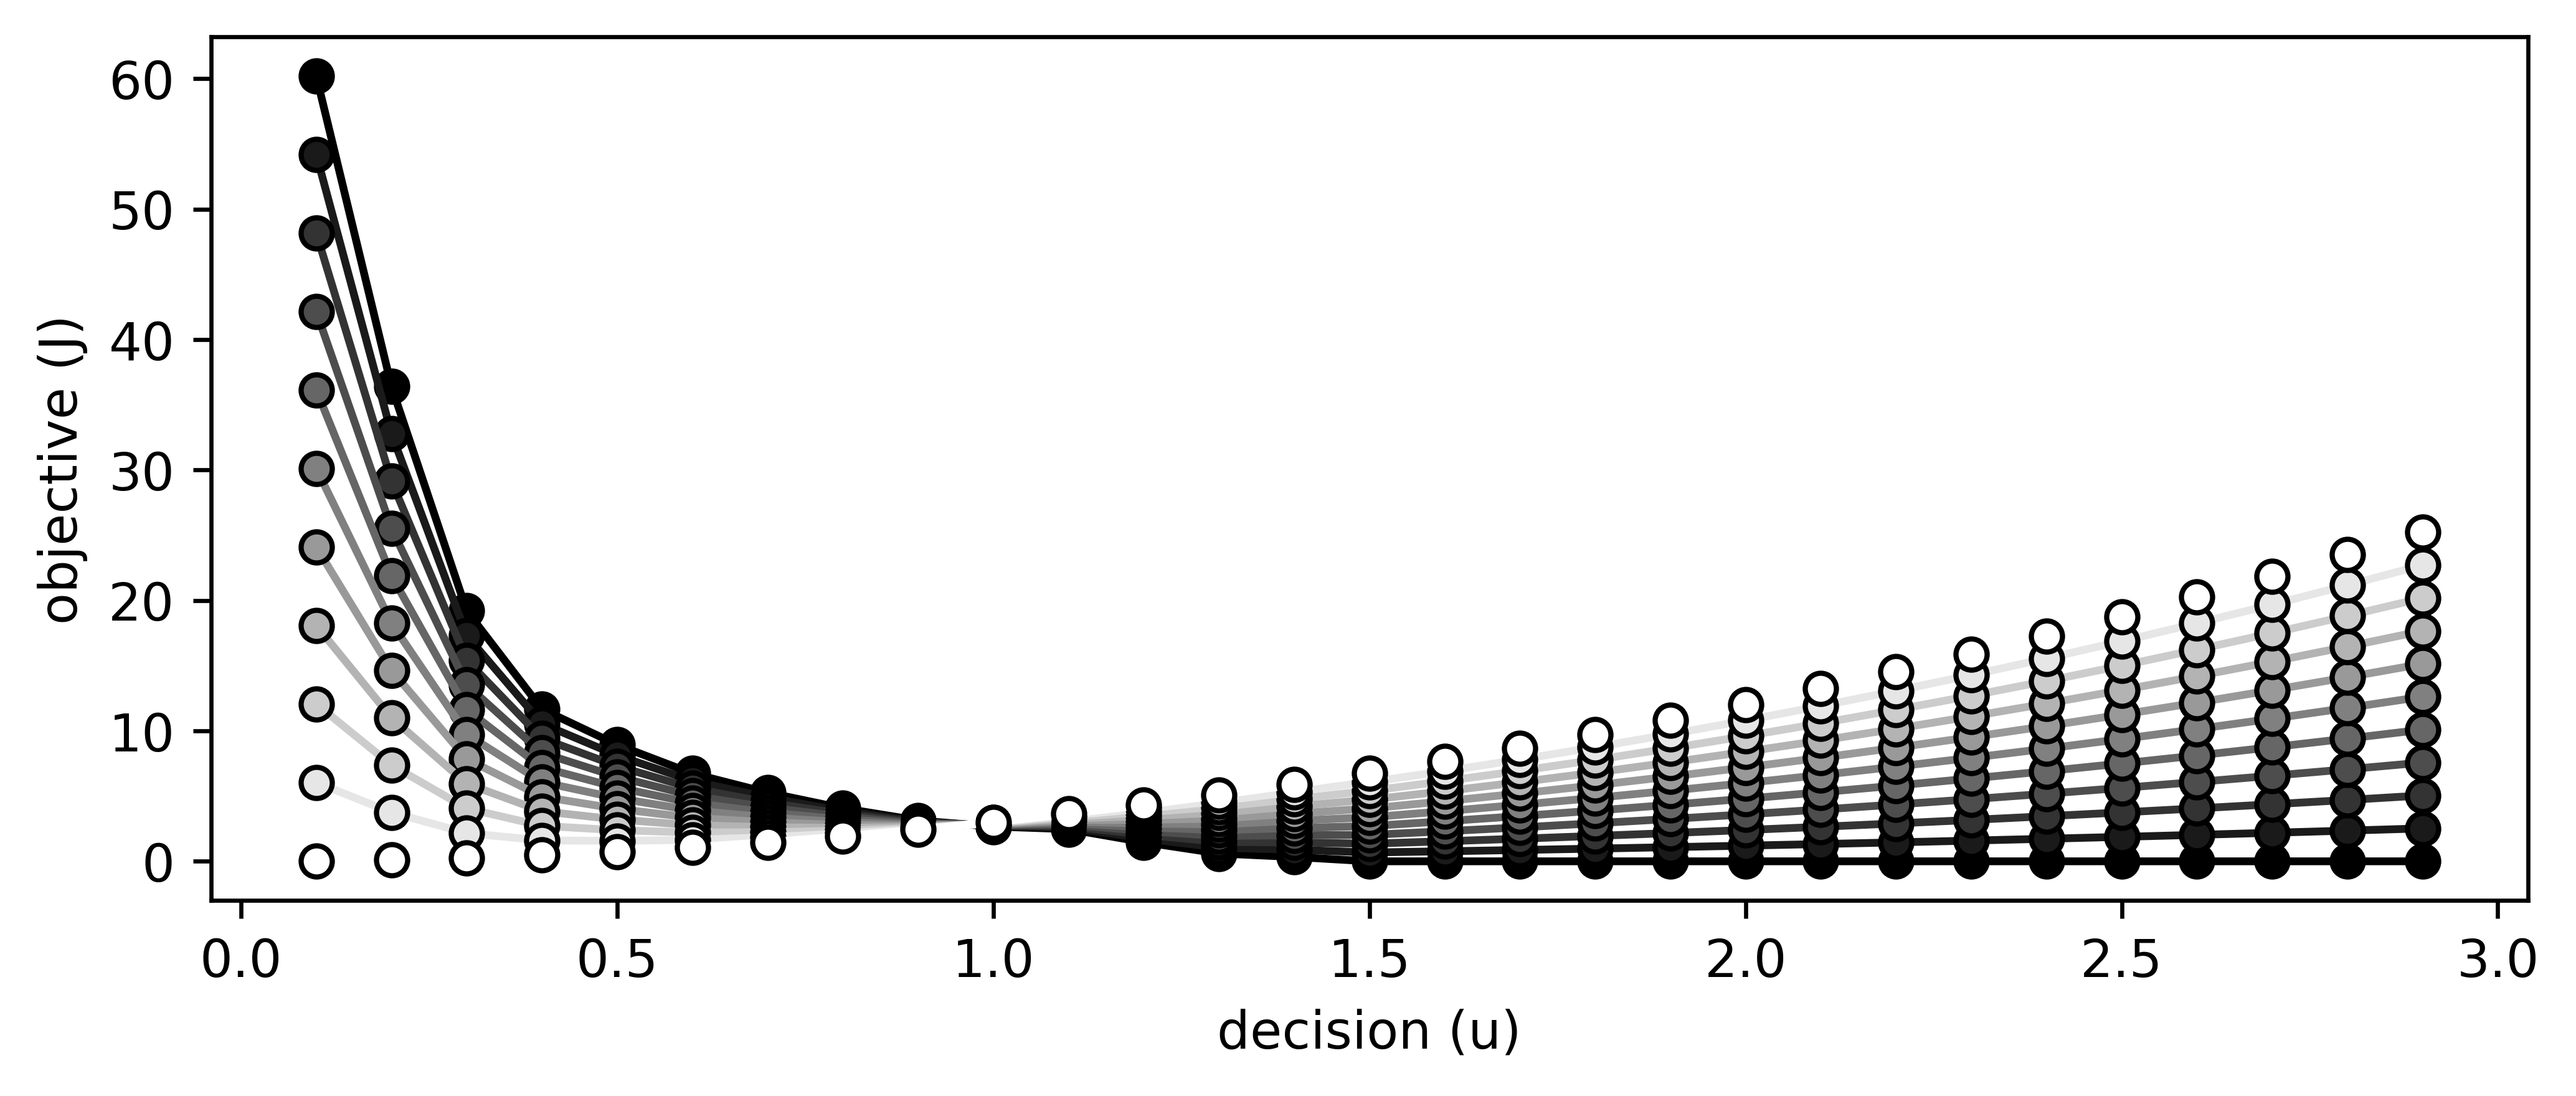

In [7]:
# external for loop for different weights
plt.figure(figsize=(8, 3))
plt.xlabel('decision (u)')
plt.ylabel('objective (J)')
for weight in np.arange(0,1.1,0.1):
  w1 = weight
  w2 = 1 - w1
  u_ = np.arange(0.1,3,0.1)
  J_ = []

  for u in u_:
    J_.append(simulate(u))

  plt.plot(u_, J_, '-o', color = str(weight), markeredgecolor='black' )




Let's extract optimal decisions and optimal objective value:

In [8]:
optimal_obj = []
optimal_decision = []

for weight in np.arange(0, 1.1, 0.1):
  w1 = weight
  w2 = 1 - w1
  u_ = np.arange(0.1,3,0.1)
  J_ = []

  for u in u_:
    J_.append(simulate(u))

  id = np.argmin(J_)
  optimal_obj.append(J_[id])
  optimal_decision.append(u_[id])

  print('cost weight:  ', weight, ', optimal reservoir size:  ',  u_[id], ', optimal objective value:   ', J_[id])
# annoying values due to floating-point precision


cost weight:   0.0 , optimal reservoir size:   1.5000000000000002 , optimal objective value:    0.0
cost weight:   0.1 , optimal reservoir size:   1.5000000000000002 , optimal objective value:    0.6750000000000003
cost weight:   0.2 , optimal reservoir size:   1.5000000000000002 , optimal objective value:    1.3500000000000005
cost weight:   0.30000000000000004 , optimal reservoir size:   1.3000000000000003 , optimal objective value:    1.9409233016800593
cost weight:   0.4 , optimal reservoir size:   1.3000000000000003 , optimal objective value:    2.387934258582908
cost weight:   0.5 , optimal reservoir size:   0.9 , optimal objective value:    2.781380569758948
cost weight:   0.6000000000000001 , optimal reservoir size:   0.9 , optimal objective value:    2.711104455807159
cost weight:   0.7000000000000001 , optimal reservoir size:   0.8 , optimal objective value:    2.5637772096420743
cost weight:   0.8 , optimal reservoir size:   0.6 , optimal objective value:    2.21042074506939

# From single objective to multiple objectives with weighted method

In [9]:
# First, let's define the same simulate(u) function that returns both objectives.
def simulate_twoObjs(u):

  S = u*1e10
  # time convention
  inflow_ = np.concatenate(([-999], inflow))
  release_ = np.concatenate(([-999], release))

  # initialize storage vector
  s = np.zeros(len(inflow_))
  l = np.zeros(len(inflow_))
  r = np.zeros(len(inflow_))

  s[0] = S*0.7

  # mass balance
  for t in range(H):
    evaporation_t = evap[t%365]/1000*s[t]*stor_to_surface/sim_step
    ##### new
    # check release constraints
    r[t+1] = min( release_[t+1], s[t] )
    #####
    s[t+1] = s[t] + (inflow_[t+1] - r[t+1] - evaporation_t)*sim_step

    # check negative
    s[t+1] = max(0, s[t+1])

    l[t+1] = 0.0521*(s[t+1]**0.3589)   ### now in the for loop and before constraints

    s[t+1] = min(s[t+1], S) #check max and min storage physical constraints


  ### calculate indicators
  #indicator 1: construction cost
  J1 = 3*u**2  #np.sum(np.maximum(80 - r[1:], 0))

  #indicator 2: flood days
  Ny = len(l)/365
  l_threshold = 0.0521*(S**0.3589)
  J2 = np.sum(l > l_threshold)/Ny


  return J1, J2



Text(0.5, 1.0, 'Pareto front of optimal solutions')

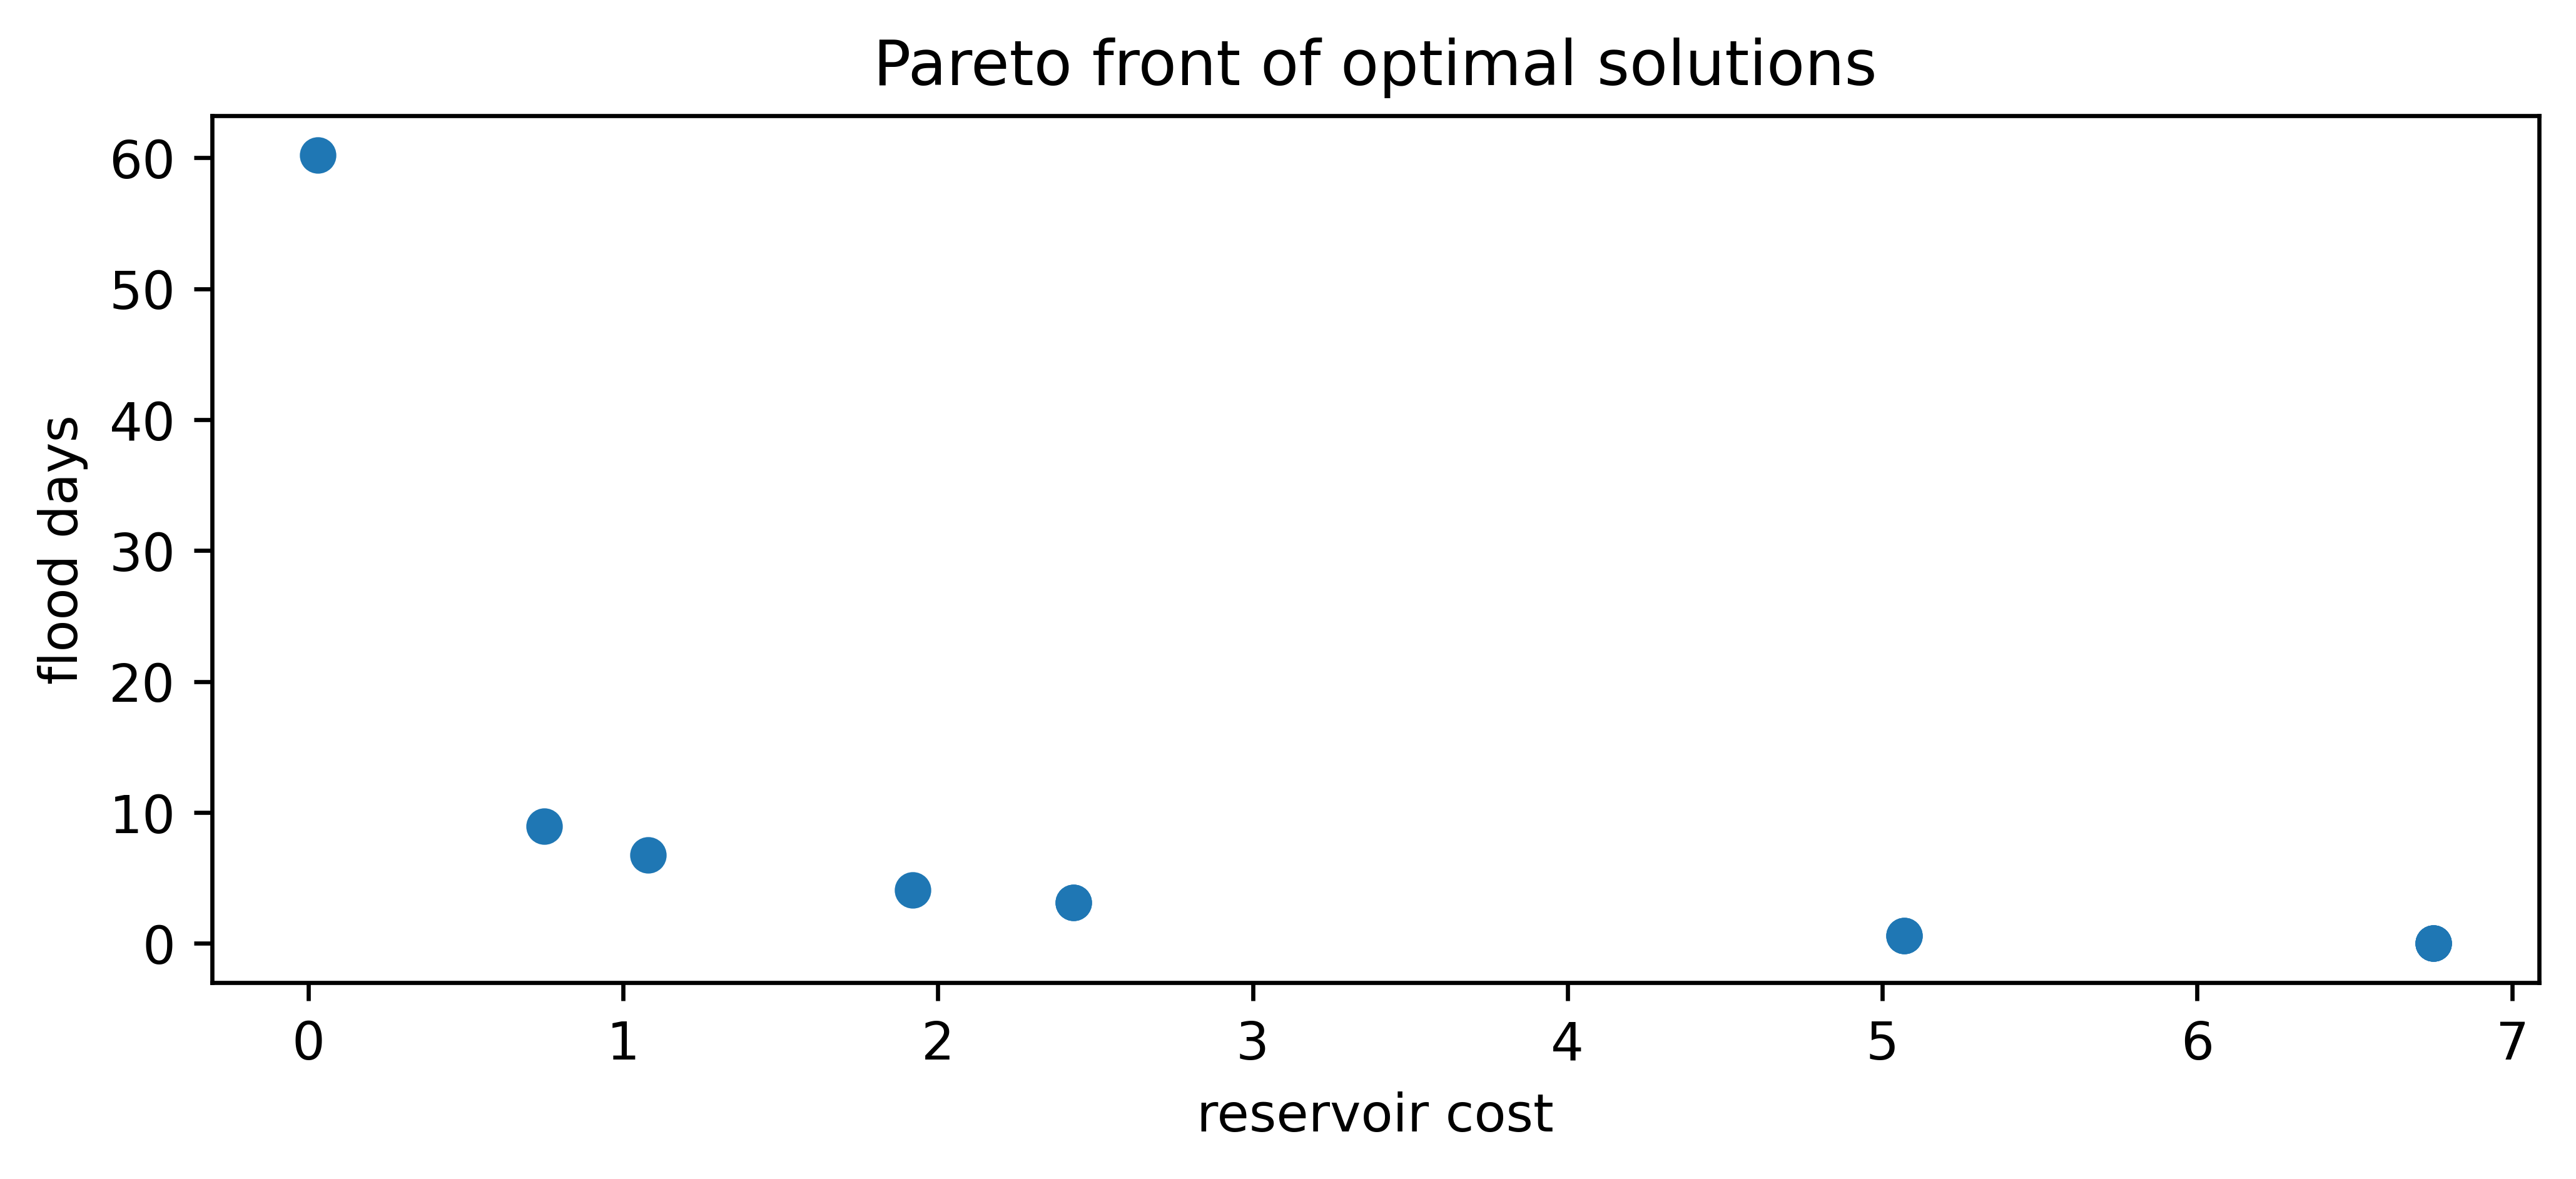

In [10]:
# Then, let's run it with the optimal decisions.
plt.figure(figsize=(8, 3))
J1 = []
J2 = []
for u in optimal_decision:
  j1, j2 = simulate_twoObjs(u)
  J1.append(j1)
  J2.append(j2)

plt.scatter(J1,J2)

plt.xlabel('reservoir cost')
plt.ylabel('flood days')
plt.title('Pareto front of optimal solutions')

# 1b. weighted method and Random search approach

best decision of the seed:  [1.24278898] objective value:  2.6833863942434535
best decision of the seed:  [1.24216796] objective value:  2.6810715819806443
best decision of the seed:  [1.24471751] objective value:  2.690582235298394
best decision of the seed:  [1.24530359] objective value:  2.692771258565025
best decision of the seed:  [1.25032891] objective value:  2.7115832977241667
best decision of the seed:  [1.24270506] objective value:  2.6830734967624896
best decision of the seed:  [1.2396028] objective value:  2.6715223770109615
best decision of the seed:  [1.23897549] objective value:  2.6691900951655994
best decision of the seed:  [0.86722508] objective value:  2.7611540817085016
best decision of the seed:  [1.24303897] objective value:  2.6843185456277974


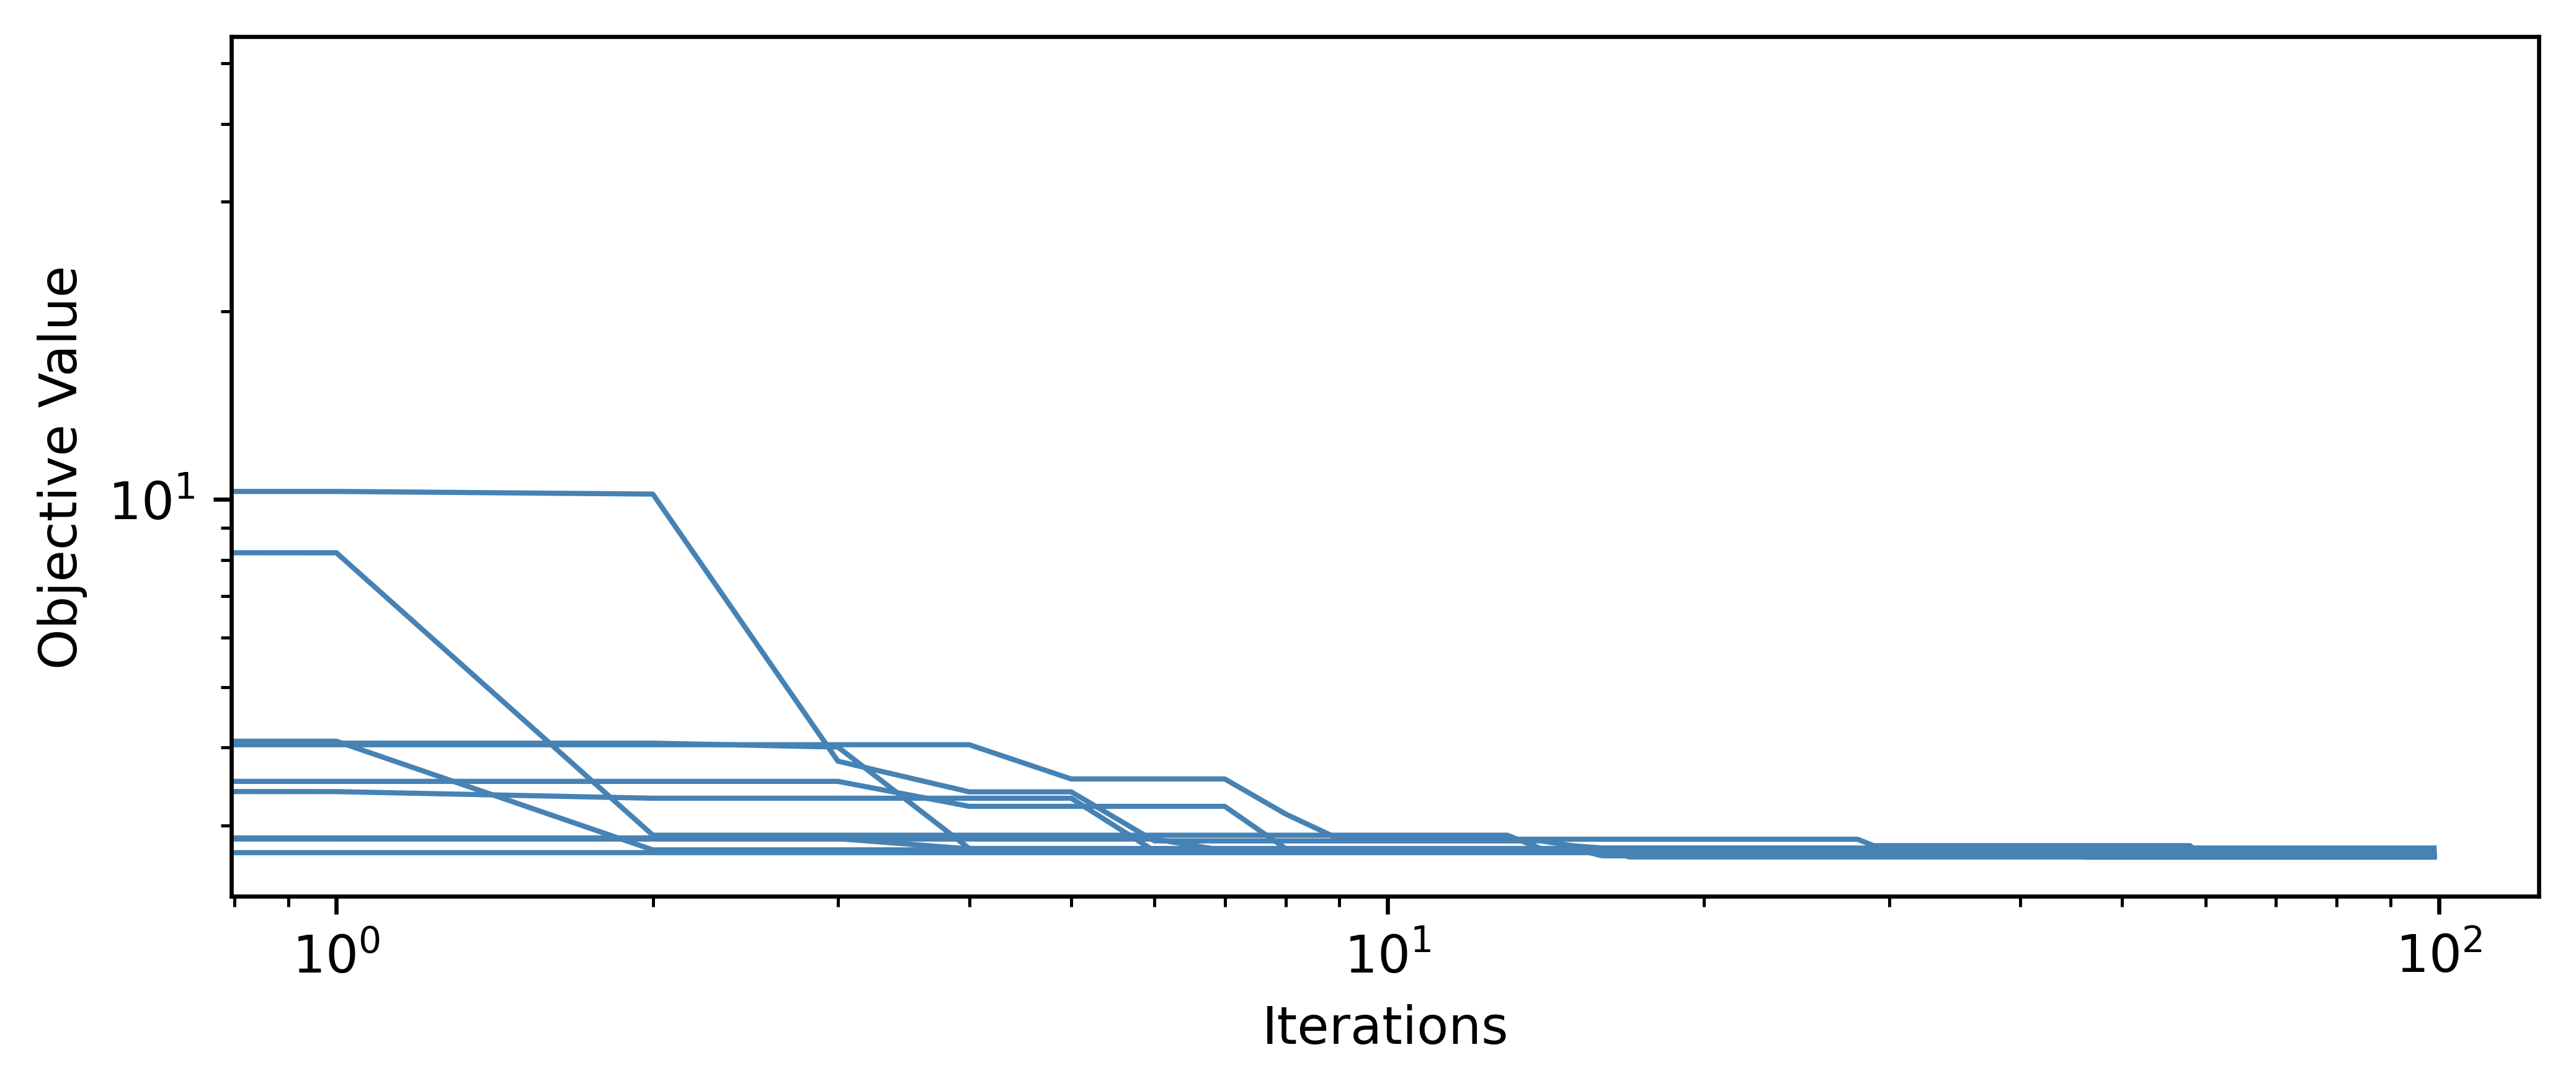

In [11]:
#upper and lower bound of decision
ub = 3
lb = 0

d = 1 # dimension of decision variable vector
num_seeds = 10
max_NFE = 100 # number of function evaluations in each seed
ft = np.zeros((num_seeds, max_NFE)) # where we will store our results

# starting with one pair of weights
w1 = 0.5
w2 = 0.5

# pure random search
for seed in range(num_seeds):

  np.random.seed(seed)
  best_u = None
  best_J = None

  for i in range(max_NFE):

    u = np.random.uniform(lb, ub, d)
    J = simulate(u[0])

    # we keep track of the "best" solution found so far
    if best_J is None or J < best_J:
      best_u = u
      best_J = J

    ft[seed,i] = best_J

  # for each trial print the result (but the traces are saved in ft)
  print('best decision of the seed: ', best_u, 'objective value: ', best_J)


plt.figure(figsize=(8, 3))
plt.loglog(ft.T, color='steelblue', linewidth=1)
plt.xlabel('Iterations')
plt.ylabel('Objective Value')
plt.show()

#2a. MO + Random search
Now, let's use random search method to find optimal reservoir size.

In [12]:
#Identifying the Pareto front from a set of possible points. Assumes minimization

def dominates(a,b): # function that checks if a dominates b
  return (np.all(a <= b) and np.any(a < b))

#The function pareto_sort accepts a matrix of points, returns a matrix of only the nondominated ones. It is not the most efficient method to do this.
#keep is an array of booleans used to index the matrix at the end

def pareto_sort(P):
    N = len(P)
    keep = np.ones(N, dtype=bool) # all True to start

    for i in range(N):
        for j in range(i+1,N):
            if keep[j] and dominates(P[i,:], P[j,:]):
                keep[j] = False

            elif keep[i] and dominates(P[j,:], P[i,:]):
                keep[i] = False

    return P[keep,:] # only keeping the nondominated points

Let's use random optimization again:

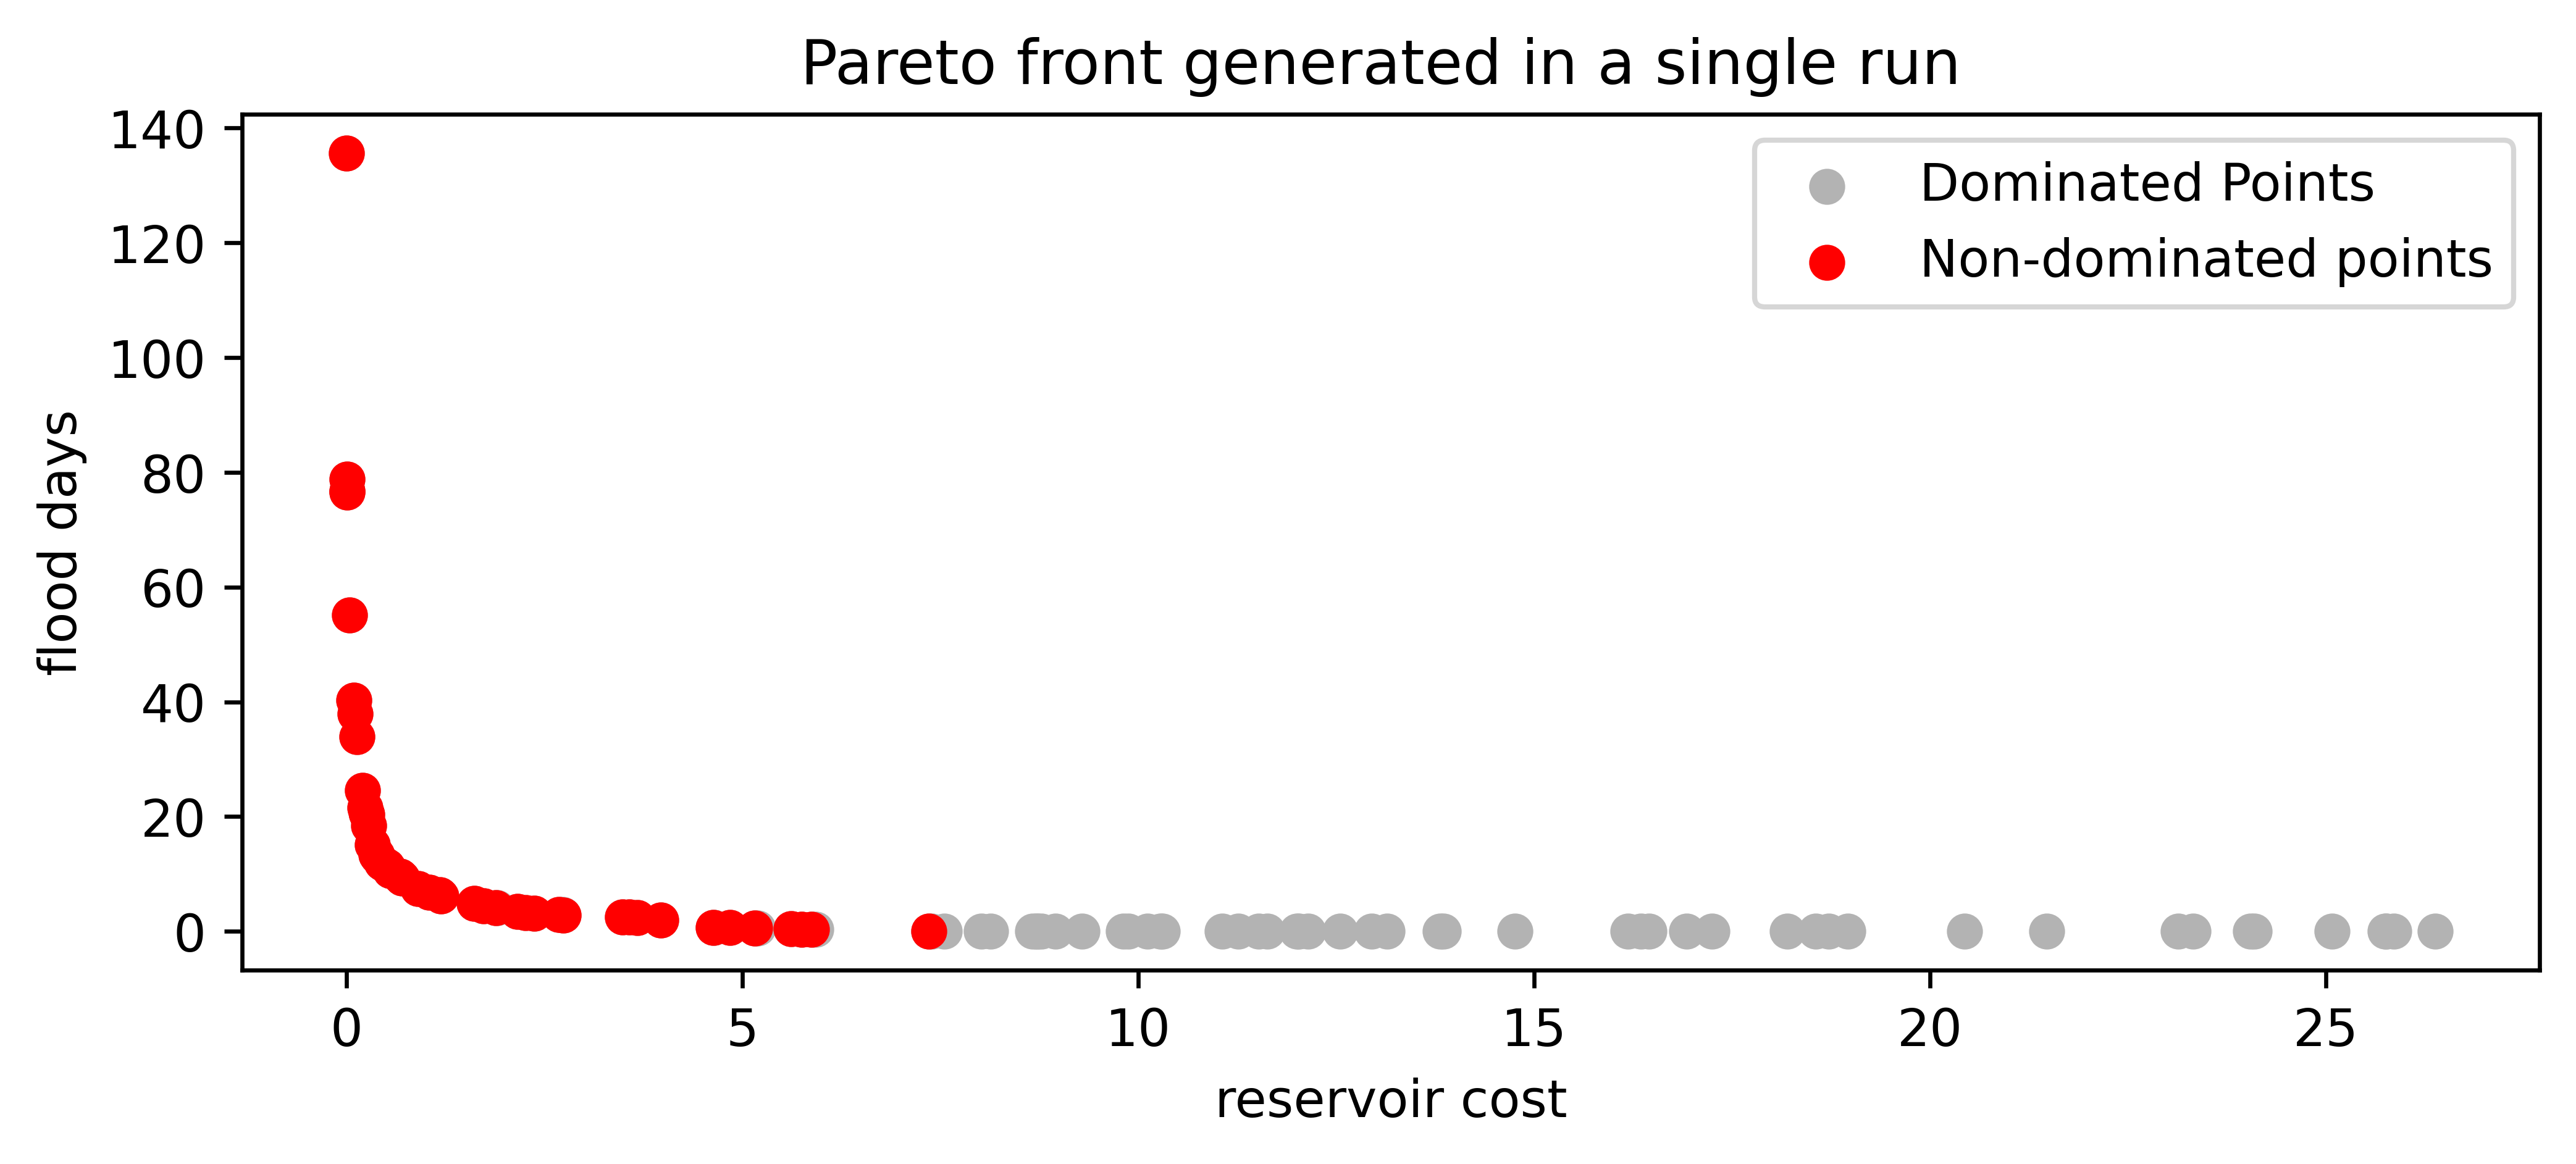

In [13]:
#upper and lower bound of decision
ub = 3
lb = 0

d = 1 # dimension of decision variable space
num_seeds = 1 # for simplicity, just one seed to have a look at the results
max_NFE = 100 # number of function evaluations in each seed
ft = np.zeros((num_seeds, max_NFE))

# pure random search
for seed in range(num_seeds):

  np.random.seed(seed)
  u = np.zeros((max_NFE,1))
  J = np.zeros((max_NFE,2))

  for i in range(max_NFE):

    u[i] = np.random.uniform(lb, ub, d)
    j1, j2 = simulate_twoObjs(u[i][0])
    J[i] = [j1, j2]

  # in the MO version, instead of keeping track of the best solution, we save all the solutions and find the non-dominated ones at the end
  J_efficient = pareto_sort(J)

  plt.figure(figsize=(8, 3))
  plt.scatter(J[:,0],J[:,1], c='0.7')
  plt.scatter(J_efficient[:,0], J_efficient[:,1], c='red')
  plt.xlabel('reservoir cost')
  plt.ylabel('flood days')
  plt.legend(['Dominated Points', 'Non-dominated points'])
  plt.title('Pareto front generated in a single run ')
  plt.show()


#2b. Multi Objective Evolutionary Algorithm (MOEA)

In [14]:
!pip install platypus-opt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 4.4 MB/s eta 0:00:00


before defining the problem, we have to slightly modify the simulate function or we'll get a type issue.

u --> u[0]

In [15]:
def simulate_twoObjs_MOEA(u):

  S = u[0]*1e10
  # time convention
  inflow_ = np.concatenate(([-999], inflow))
  release_ = np.concatenate(([-999], release))

  # initialize storage vector
  s = np.zeros(len(inflow_))
  l = np.zeros(len(inflow_))
  r = np.zeros(len(inflow_))

  s[0] = S*0.7

  # mass balance
  for t in range(H):
    evaporation_t = evap[t%365]/1000*s[t]*stor_to_surface/sim_step
    ##### new
    # check release constraints
    r[t+1] = min( release_[t+1], s[t] )
    #####
    s[t+1] = s[t] + (inflow_[t+1] - r[t+1] - evaporation_t)*sim_step

    # check negative
    s[t+1] = max(0, s[t+1])

    l[t+1] = 0.0521*(s[t+1]**0.3589)   ### now in the for loop and before constraints

    s[t+1] = min(s[t+1], S) #check max and min storage physical constraints


  ### calculate indicators
  #indicator 1: construction cost
  J1 = 3*u[0]**2

  #indicator 2: flood days
  Ny = len(l)/365
  l_threshold = 0.0521*(S**0.3589)
  J2 = np.sum(l > l_threshold)/Ny


  return J1, J2

### How to use Platypus to solve an optimization problem via MOEA

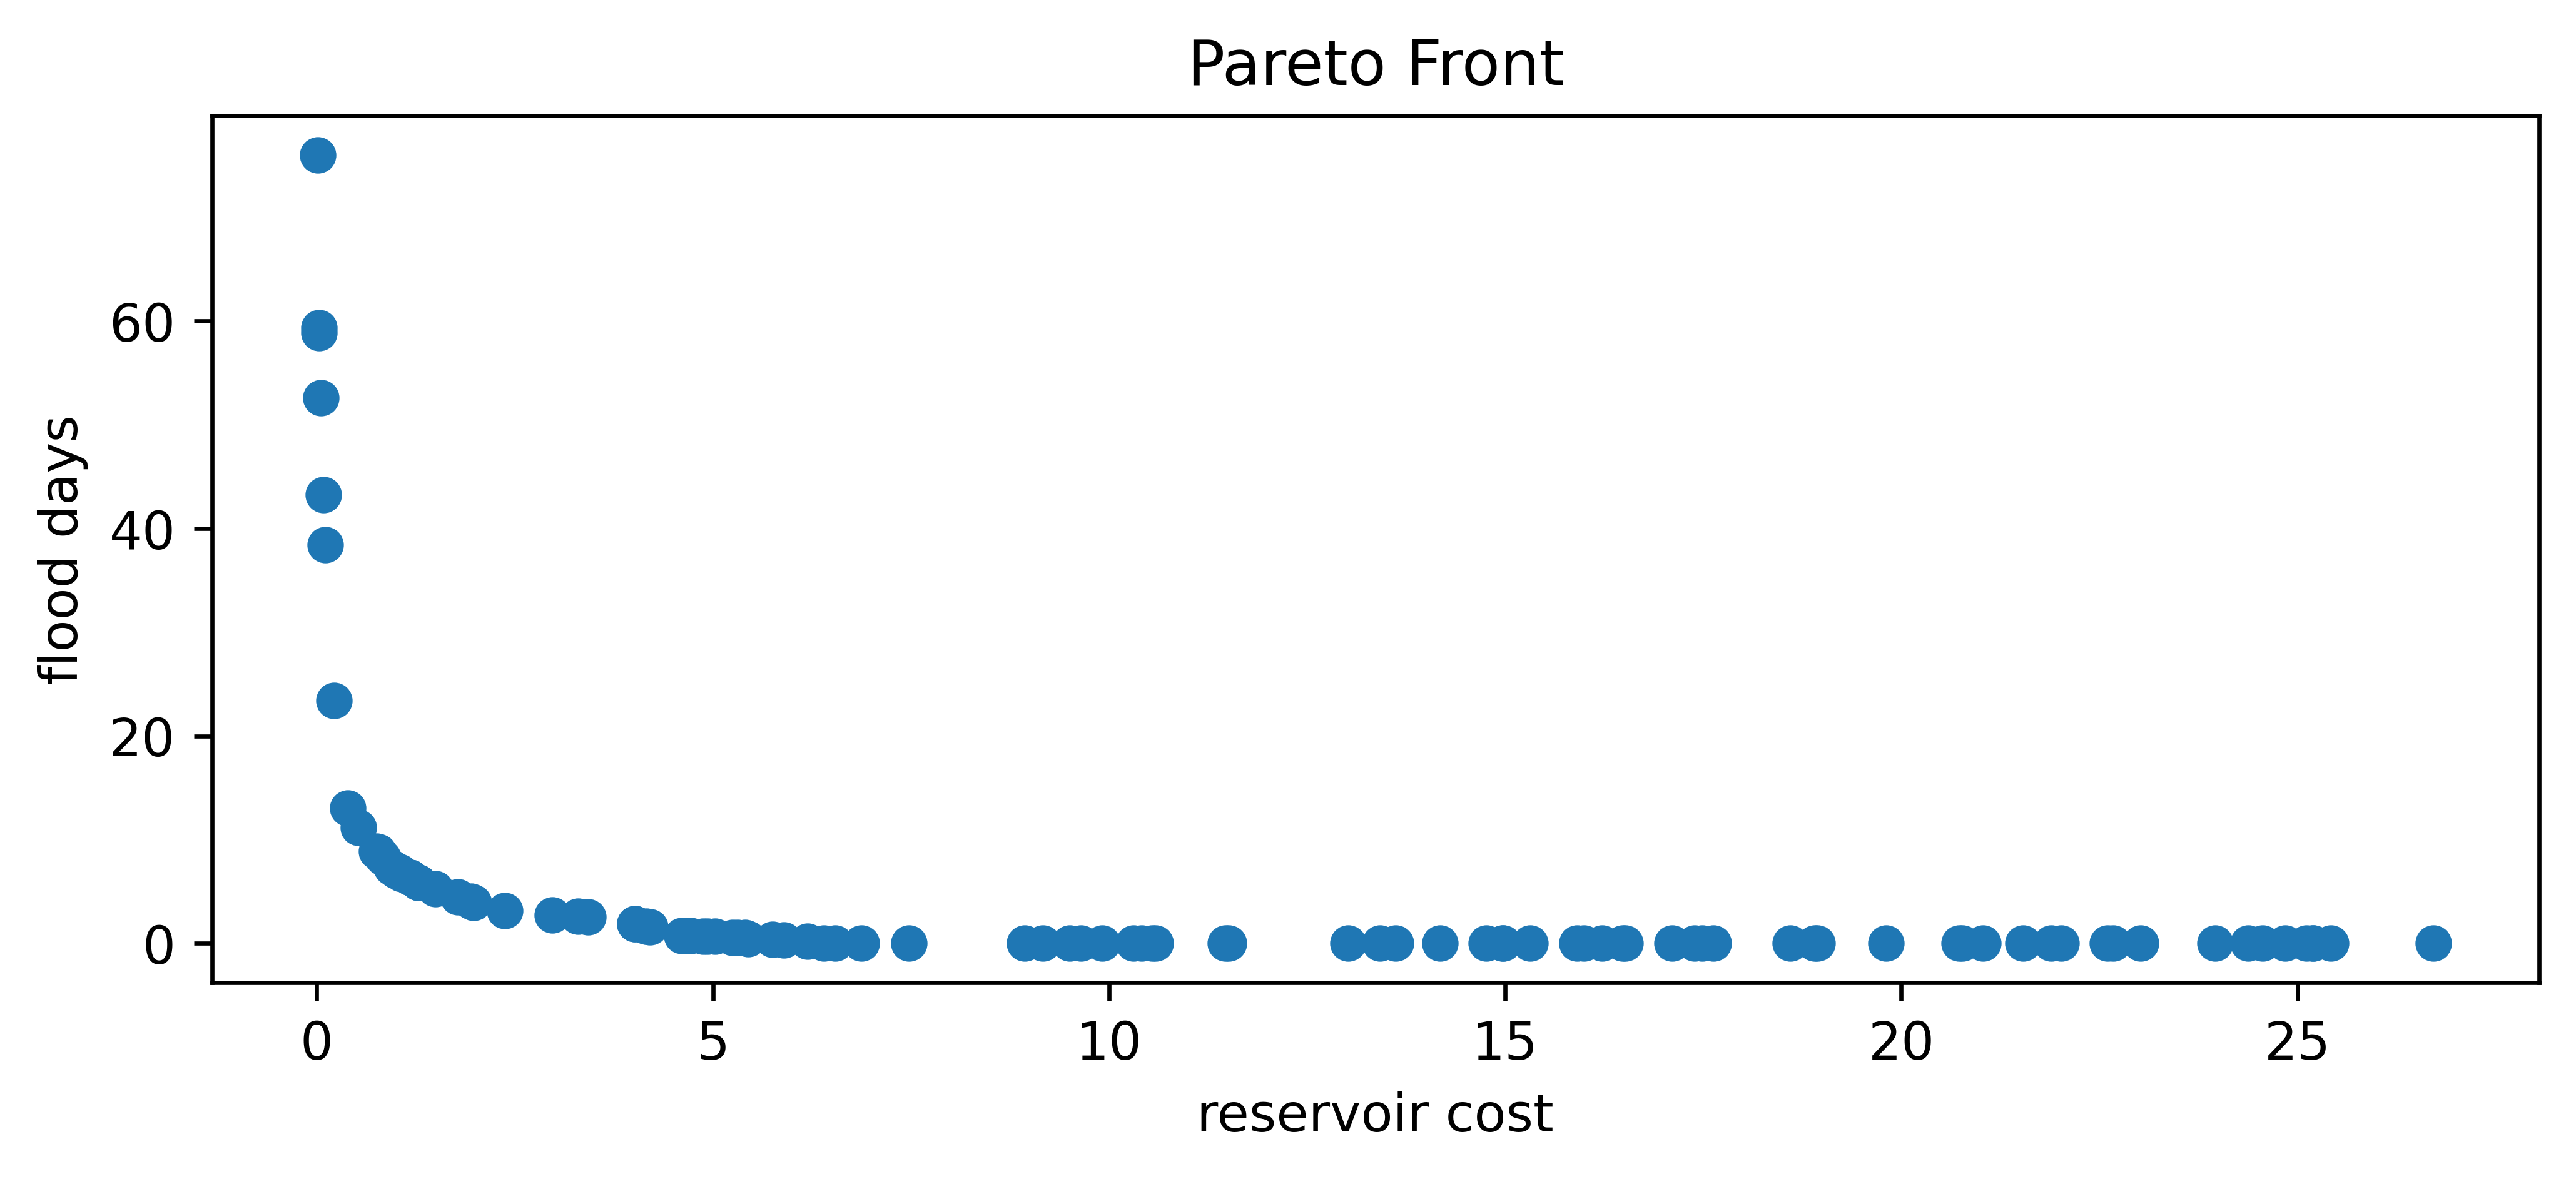

In [19]:
from platypus import MOEAD, Problem, Real

problem = Problem(1, 2)
problem.types[:] = Real(lb, ub)
problem.function = simulate_twoObjs_MOEA
algorithm = MOEAD(problem)

#Optimize the problem using max_NFE function evaluations
max_NFE = 200 # try changing this!
algorithm.run(max_NFE)

#Convert results to numpy arrays

J = np.array([s.objectives for s in algorithm.result])
u = np.array([s.variables for s in algorithm.result])


plt.figure(figsize=(8, 3))
plt.scatter(J[:,0],J[:,1])
plt.xlabel('reservoir cost')
plt.ylabel('flood days')
plt.title('Pareto Front')
plt.show()



In [ ]:
print(J)

[[9.84099838e-03 7.83856830e+01]
 [7.67977146e-01 8.79839299e+00]
 [8.31101299e+00 0.00000000e+00]
 [7.75200157e+00 0.00000000e+00]
 [9.44494532e+00 0.00000000e+00]
 [8.16191502e+00 0.00000000e+00]
 [6.01311851e+00 2.66617969e-01]
 [7.33705918e+00 0.00000000e+00]
 [6.91864085e+00 0.00000000e+00]
 [5.55822094e+00 4.66581446e-01]
 [7.63347552e+00 0.00000000e+00]
 [7.58257730e+00 0.00000000e+00]
 [8.15584966e+00 0.00000000e+00]
 [5.29273369e+00 5.33235939e-01]
 [6.03088270e+00 2.66617969e-01]
 [7.77843697e+00 0.00000000e+00]
 [7.44279124e+00 0.00000000e+00]
 [3.06204093e+00 2.66617969e+00]
 [4.87971970e+00 6.66544923e-01]
 [6.55573971e+00 0.00000000e+00]
 [8.27431749e+00 0.00000000e+00]
 [6.88586295e+00 0.00000000e+00]
 [5.98816333e+00 2.66617969e-01]
 [6.61595689e+00 0.00000000e+00]
 [3.66648173e+00 2.39956172e+00]
 [4.47749603e+00 1.13312637e+00]
 [4.60357846e+00 7.33199416e-01]
 [1.51042695e+01 0.00000000e+00]
 [3.92565534e+00 2.26625274e+00]
 [4.28910111e+00 1.46639883e+00]
 [1.300116